In [26]:
import pandas as pd
import numpy as np
from numpy import diff

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd
import math

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from datetime import datetime, timezone

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})


# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [27]:
## load declustered data

data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/stat-seismo-main/data/sum_20_all_nnd.h5")
# data = data[(data['magnitude'] >= 4.8)]
data.sort_values(by = 'magnitude', ascending = False, inplace = True)

data["second"] = data["seconde"]
data["date"] = pd.to_datetime(data[["year", "month", "day", "hour", "minute", "second"]]) # change dtype to datetime format

In [28]:
## select reference date, i.e. 2004 mainshock
selected_value = UTCDateTime(data["date"].loc[1513]) # or replace this with any value you want as a reference point
years_passed = []

for idx, row in data["date"].iteritems():
    years_passed.append(UTCDateTime(row) - selected_value)

years_passed = np.array(years_passed)/31536000

data["YEARS"] = years_passed
data = data.sort_values(by = "YEARS", ascending = True)
data["Days"] = data['YEARS']*365

# change the reference from the center of the earth to the surface of the earth
data['depth'] = 6371- data['depth']

In [29]:
data = data[(data['YEARS'] > -30) & (data['YEARS'] < 10) &
           (data['depth'] > 70) & (data['magnitude'] >= 1)]

In [30]:
thresh = 10**-3.5 # to differentiate background seismicity and aftershocks

data_java = data[(data['latitude'] < -2)]

# select foreshock/aftershock seismicity by apply threshold
data_foreshock_java = data_java[(data_java["Nij"] < thresh)]
data_background_java = data_java[(data_java["Nij"] > thresh)]

count_foreshock_java = data_foreshock_java['YEARS']
normalized_count_foreshock_java = count_foreshock_java / count_foreshock_java.sum()

count_background_java = data_background_java['YEARS']
normalized_count_background_java = (count_background_java - min(count_background_java)) / (max(count_background_java) - min(count_background_java))

In [31]:
data_sumatra = data[(data['latitude'] > -2)]

# select foreshock/aftershock seismicity by apply threshold
data_foreshock_sumatra = data_sumatra[(data_sumatra["Nij"] < thresh)]
data_background_sumatra = data_sumatra[(data_sumatra["Nij"] > thresh)]

count_foreshock_sumatra = data_foreshock_sumatra['YEARS']
normalized_count_foreshock_sumatra = count_foreshock_sumatra / count_foreshock_sumatra.sum()

count_background_sumatra = data_background_sumatra['YEARS']
normalized_count_background_sumatra = (count_background_sumatra - min(count_background_sumatra)) / (max(count_background_sumatra) - min(count_background_sumatra))

Text(0, 0.5, 'BSR (events/yr)')

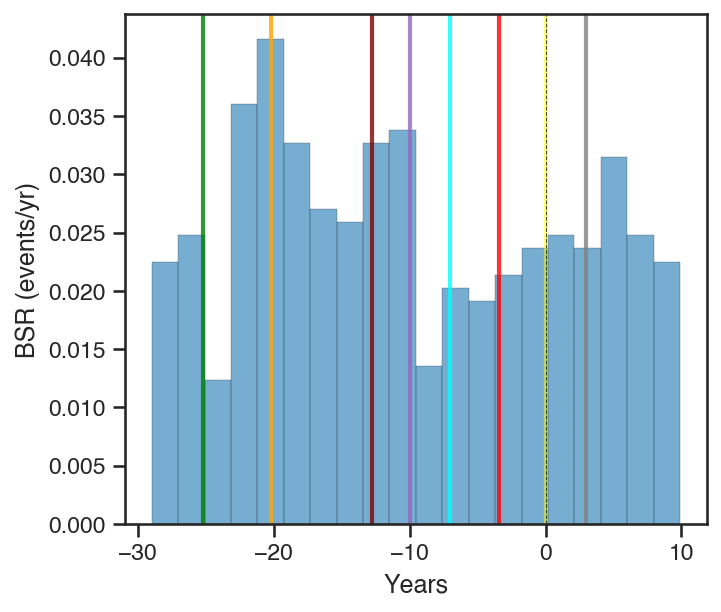

In [32]:
# group the data by year and calculate the seismicity rate per year
total_yrs = 31

seismicity_rate_sumatra = data_background_sumatra.groupby("YEARS").size() / total_yrs
seismicity_rate_java = data_background_java.groupby("YEARS").size() / total_yrs

# plot the seismicity rate over time
figsize = (5,4.5)
dpi=150

fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi, sharex= False)
fig1=ax
# fig2=ax[1]


bins = 20
alpha = 0.6

# fig1.hist(seismicity_rate_java.index, bins=bins, weights=seismicity_rate_java.values,
#         histtype='step', cumulative='True', lw=2, alpha=0.9, color='tab:blue', label='Long slab')

# fig1.hist(seismicity_rate_sumatra.index, bins=bins, weights=seismicity_rate_sumatra.values,
#         histtype='step', cumulative='True', lw=2, alpha=0.9, color='tab:green', label='Short slab')

fig1.hist(seismicity_rate_java.index, bins=bins, weights=seismicity_rate_java.values,
          density=True,
          edgecolor='k', lw=0.2, alpha=alpha, color='tab:blue')

# fig1.hist(seismicity_rate_sumatra.index, bins=bins, weights=seismicity_rate_sumatra.values,
#           edgecolor='k', lw=1, alpha=alpha, color='tab:red')
    

# fig1.set_xlim([-5, 5])

# fig1.legend(loc = 'lower right',
#             fontsize = 8,
#             framealpha=1,
#            facecolor='white',
#             edgecolor="grey",
#             markerscale=0.1)

alpha=0.8
lw = 2
# bands left to right
fig1.axvline(x=-25.2, color='green', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-20.2, color='orange', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-12.8, color='maroon', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-10, color='tab:purple', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-7, color='cyan', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=-3.4, color='red', lw=lw, ls='-', alpha=alpha)
fig1.axvline(x=0, color='yellow', lw=lw, ls='-', alpha=0.5)
fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=0.8)
fig1.axvline(x=2.95, color='grey', lw=lw, ls='-', alpha=alpha)

# fig1.yaxis.tick_right()
# fig1.yaxis.set_label_position("right")

fig1.set_xlabel("Years")
fig1.set_ylabel("BSR (events/yr)")

# plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/BSR_shallowJava.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')